In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.decomposition import PCA
import random

LIST_PATH   = Path(r"C:\PHY199\list_file_9.txt")
MATRIX_PATH = Path(r"C:\PHY199\flux_matrix_9.txt")

rows = []
for ln in LIST_PATH.read_text().splitlines():
    if ln.strip():
        pieces = {k.strip(): v.strip() for k, v in
                  (kv.split(':',1) for kv in ln.split(','))}
        # ... your existing parsing logic for each row ...
        rows.append(pieces)


meta = (pd.DataFrame(rows)
          .rename(columns={'Spec1D File':'fname','Redshift':'z',
                           'lambda_min':'lam_min_obs','lambda_max':'lam_max_obs'})
          .astype({'z':float,'lam_min_obs':float,'lam_max_obs':float}))
meta['lam_min_rest'] = meta['lam_min_obs']/(1+meta['z'])
meta['lam_max_rest'] = meta['lam_max_obs']/(1+meta['z'])

flux_matrix = pd.read_csv(MATRIX_PATH, sep=' ', header=None).values
wavelengths = np.arange(3683, 5300.01, 0.3)

pca        = PCA(n_components=3)
scores     = pca.fit_transform(flux_matrix)
meta['PC3'] = scores[:,2]


In [ ]:
def g_const(l, A, mu, sig, C):
    return C + A*np.exp(-(l-mu)**2/(2*sig**2))

def oii_doublet(l, A1,A2, mu1,mu2, sig, C):
    g1 = A1*np.exp(-(l-mu1)**2/(2*sig**2))
    g2 = A2*np.exp(-(l-mu2)**2/(2*sig**2))
    return C + g1 + g2

OII1, OII2 = 3726.03, 3728.82   # Å
OIII       = 5008.240

records = []
for i, row in meta.iterrows():
    if not (row.lam_min_rest < 3706 and row.lam_max_rest > 5028):
        continue
    
    spec = flux_matrix[i]
    
    # [O III] single Gaussian
    msk = (wavelengths > OIII-10) & (wavelengths < OIII+10)
    x3, y3 = wavelengths[msk], spec[msk]
    try:
        p0 = [y3.max()-y3.min(), OIII, 1.0, np.median(y3)]
        popt3,_ = curve_fit(g_const, x3, y3, p0=p0, maxfev=10000)
        A3, mu3, sig3, C3 = popt3
        F_OIII = A3*sig3*np.sqrt(2*np.pi)
    except RuntimeError:
        continue
    
    # [O II] doublet
    msk = (wavelengths > OII1-8) & (wavelengths < OII2+8)
    x2, y2 = wavelengths[msk], spec[msk]
    try:
        p0 = [(y2.max()-y2.min())/2]*2 + [OII1,OII2,1.0,np.median(y2)]
        bounds = ([0,0,OII1-1,OII2-1,0.3,-np.inf],
                  [np.inf,np.inf,OII1+1,OII2+1,3.0,np.inf])
        popt2,_ = curve_fit(oii_doublet, x2, y2, p0=p0,
                            bounds=bounds, maxfev=20000)
        A1,A2,mu1,mu2,sig2,C2 = popt2
        F_OII = (A1 + A2) * sig2 * np.sqrt(2*np.pi)
    except RuntimeError:
        continue
    
    # flux cuts 
    if F_OII <= 50 or F_OIII <= 80:
        continue
    
    records.append(dict(idx=i,
                        PC3=row.PC3,
                        flux_OII=F_OII,
                        flux_OIII=F_OIII,
                        ratio=F_OII/F_OIII,
                        # store params so we can re-draw the fit
                        p_OIII=popt3,
                        p_OII =popt2 ))
    
results = pd.DataFrame(records)
print("Spectra kept:", len(results))

C:\Users\user1\AppData\Local\Temp\ipykernel_42796\490994948.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  popt3,_ = curve_fit(g_const, x3, y3, p0=p0, maxfev=10000)


Spectra kept: 305


Removed 19 outliers by PC3; remaining for fit: 286


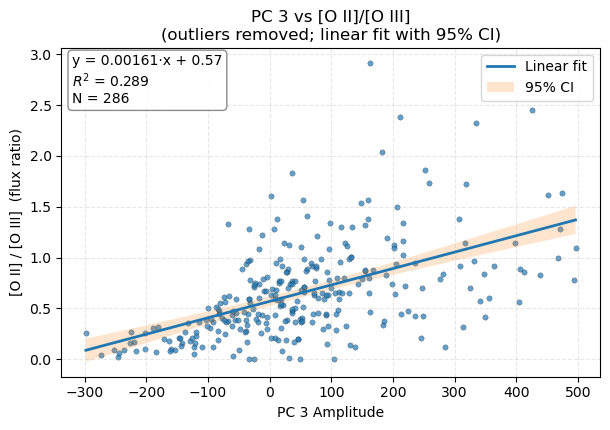

In [ ]:
# delete PC3 outliers, then fit regression 
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Use your desired bounds
LOW_CUT, HIGH_CUT = -300, 500   # change to 550 if you prefer

# Clean ONLY the numeric columns we need to fit/plot
numcols = ['PC3', 'ratio']
clean_base = (results.loc[:, numcols]
                        .apply(pd.to_numeric, errors='coerce')
                        .replace([np.inf, -np.inf], np.nan)
                        .dropna())

# Remove PC3 outliers
is_outlier = (clean_base['PC3'] < LOW_CUT) | (clean_base['PC3'] > HIGH_CUT)
clean = clean_base.loc[~is_outlier].copy()

print(f"Removed {int(is_outlier.sum())} outliers by PC3; remaining for fit: {len(clean)}")

# Linear regression on cleaned data
x = clean['PC3'].to_numpy(dtype=float)
y = clean['ratio'].to_numpy(dtype=float)
n = len(clean)

if n < 3:
    raise ValueError("Not enough points after outlier removal to fit regression.")

lin = stats.linregress(x, y)
m, b, r2 = lin.slope, lin.intercept, lin.rvalue**2

# Predicted line
x_line = np.linspace(x.min(), x.max(), 300)
y_line = m * x_line + b

# 95% CI for the mean regression line y|x
y_hat = m * x + b
s_err = np.sqrt(np.sum((y - y_hat)**2) / (n - 2))

x_mean = x.mean()
Sxx = np.sum((x - x_mean)**2)
if Sxx == 0:
    raise ValueError("PC3 has zero variance after filtering; cannot fit regression.")

t_val = stats.t.ppf(1 - 0.025, df=n - 2)
se_mean = s_err * np.sqrt((1/n) + ((x_line - x_mean)**2 / Sxx))
ci_upper = y_line + t_val * se_mean
ci_lower = y_line - t_val * se_mean

# 5) Plot
plt.figure(figsize=(6.2, 4.4))
plt.scatter(clean['PC3'], clean['ratio'], s=15, alpha=0.7, edgecolor='k', lw=0.2)
plt.plot(x_line, y_line, lw=2, label='Linear fit')
plt.fill_between(x_line, ci_lower, ci_upper, alpha=0.2, label='95% CI')

plt.xlabel('PC 3 Amplitude')
plt.ylabel('[O II] / [O III]  (flux ratio)')
plt.title('PC 3 vs [O II]/[O III]\n(outliers removed; linear fit with 95% CI)')
plt.grid(ls='--', alpha=0.3)

eq = f"y = {m:.3g}·x + {b:.3g}\n$R^2$ = {r2:.3f}\nN = {n}"
plt.annotate(eq, xy=(0.02, 0.98), xycoords='axes fraction',
             va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.9))

plt.legend()
plt.tight_layout()
plt.show()


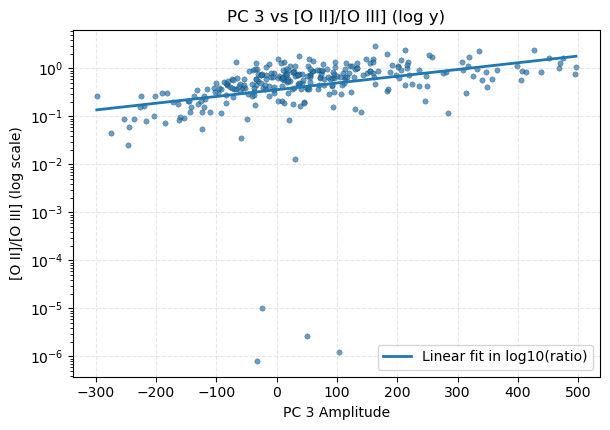

In [5]:
# keep only physically sensible ratios
df = clean[clean['ratio'] > 0].copy()

x = df['PC3'].to_numpy(float)
y = np.log10(df['ratio'].to_numpy(float))

lin = stats.linregress(x, y)   # fit in log space
m, b, r2 = lin.slope, lin.intercept, lin.rvalue**2

# plot (points in original scale, axis logged) – OR just plot log values directly
plt.figure(figsize=(6.2,4.4))
plt.scatter(df['PC3'], df['ratio'], s=15, alpha=0.7, edgecolor='k', lw=0.2)
plt.yscale('log')  # compress y visually
# regression line drawn in original scale using log fit:
x_line = np.linspace(x.min(), x.max(), 300)
y_line = 10**(m*x_line + b)
plt.plot(x_line, y_line, lw=2, label='Linear fit in log10(ratio)')
plt.xlabel('PC 3 Amplitude')
plt.ylabel('[O II]/[O III] (log scale)')
plt.title('PC 3 vs [O II]/[O III] (log y)')
plt.grid(ls='--', alpha=0.3)
plt.legend(); plt.tight_layout(); plt.show()


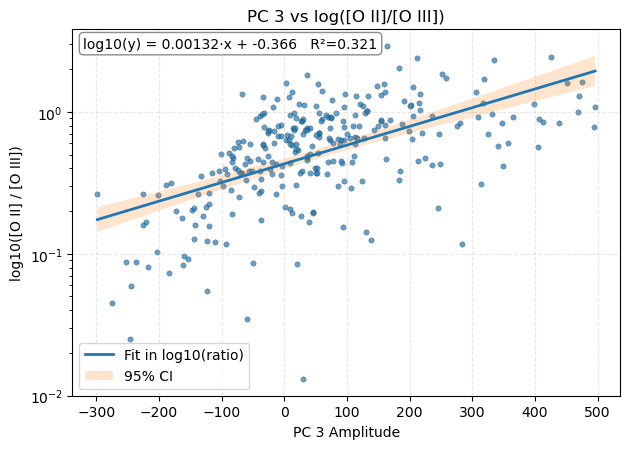

In [ ]:
# Remove 4 outliers in log10(ratio) and replot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

LOW_CUT, HIGH_CUT = -300, 500   # keep your PC3 window
K = 4                           # number of outliers to drop

# Build a clean base (numeric only, finite, positive ratios)
numcols = ['PC3', 'ratio']
base = (results.loc[:, numcols]
                .apply(pd.to_numeric, errors='coerce')
                .replace([np.inf, -np.inf], np.nan)
                .dropna())
base = base[(base['PC3'] >= LOW_CUT) & (base['PC3'] <= HIGH_CUT) & (base['ratio'] > 0)].copy()

# Robust extremeness on y using log10(ratio)
ylog = np.log10(base['ratio'].values)
med  = np.median(ylog)
mad  = 1.4826 * np.median(np.abs(ylog - med))  # MAD scaled to ~sigma

if mad == 0:  # fallback if all nearly equal
    q1, q3 = np.percentile(ylog, [25, 75])
    iqr = max(q3 - q1, 1e-6)
    robust_z = np.abs((ylog - np.median(ylog)) / (iqr / 1.349))
else:
    robust_z = np.abs((ylog - med) / mad)

# Indices of the K most extreme points
k = min(K, max(0, len(base) - 3))
drop_idx = np.argsort(robust_z)[-k:]
df = base.drop(base.index[drop_idx]).copy()

# Refit: linear in log10(ratio)
x = df['PC3'].to_numpy(float)
ylog = np.log10(df['ratio'].to_numpy(float))
lin = stats.linregress(x, ylog)
m, b, r2 = lin.slope, lin.intercept, lin.rvalue**2

# Build line + 95% CI in log space
x_line = np.linspace(x.min(), x.max(), 300)
ylog_line = m * x_line + b

n = len(df)
ylog_hat = m * x + b
s_err = np.sqrt(np.sum((ylog - ylog_hat)**2) / (n - 2))
x_mean = x.mean()
Sxx = np.sum((x - x_mean)**2)
t_val = stats.t.ppf(1 - 0.025, df=n - 2)
se_mean = s_err * np.sqrt((1/n) + ((x_line - x_mean)**2 / Sxx))
ci_upper_log = ylog_line + t_val * se_mean
ci_lower_log = ylog_line - t_val * se_mean

# Back-transform for plotting with log y-axis
y_line   = 10**(ylog_line)
ci_upper = 10**(ci_upper_log)
ci_lower = 10**(ci_lower_log)

# Plot
plt.figure(figsize=(6.4, 4.6))
plt.scatter(df['PC3'], df['ratio'], s=15, alpha=0.7, edgecolor='k', lw=0.2)
plt.plot(x_line, y_line, lw=2, label='Fit in log10(ratio)')
plt.fill_between(x_line, ci_lower, ci_upper, alpha=0.2, label='95% CI')
plt.yscale('log')
plt.xlabel('PC 3 Amplitude')
plt.ylabel('log10([O II] / [O III])')
plt.title('PC 3 vs log([O II]/[O III])')
plt.grid(ls='--', alpha=0.3)
eq = f"log10(y) = {m:.3g}·x + {b:.3g}   R²={r2:.3f}"
plt.annotate(eq, xy=(0.02, 0.98), xycoords='axes fraction',
             va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.9))
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Export PC scores to pc_scores_9.csv so R can read them directly
import numpy as np, pandas as pd
from pathlib import Path

# Reuse existing PCA/scores if present; otherwise compute them the same way ---
try:
    _ = scores  # already computed earlier in the notebook
    pcs = scores
except NameError:
    from sklearn.decomposition import PCA
    # If your notebook already has `flux_matrix`, reuse it; else load it here:
    try:
        _ = flux_matrix
    except NameError:
        # Adjust the path to match your notebook if needed
        MATRIX_PATH = Path("flux_matrix_9.txt")
        # If your file is space-delimited with no header:
        flux_matrix = pd.read_csv(MATRIX_PATH, sep=r"\s+", header=None).values
        # If your file has an ID in the first column, drop it:
        if flux_matrix.ndim == 2 and flux_matrix.shape[1] > 1000 and np.issubdtype(flux_matrix[:,0].dtype, np.number):
            # comment this out if your matrix already excludes ID
            pass

    pca = PCA(n_components=3)  # sklearn centers by default (no scaling), matching prior code
    pcs = pca.fit_transform(flux_matrix)

# --- Build a tidy DataFrame and save ---
df_pcs = pd.DataFrame(
    pcs[:, :3],
    columns=["PC1", "PC2", "PC3"]
)
df_pcs.insert(0, "row_index", np.arange(len(df_pcs)))  # helps align by row if needed

out_path = Path("pc_scores_9.csv")
df_pcs.to_csv(out_path, index=False)
print(f"Saved {len(df_pcs)} rows to {out_path.resolve()}")
df_pcs.head()


Saved 2294 rows to C:\PHY199\pc_scores_9.csv


,row_index,PC1,PC2,PC3
0,0,-148.459764,-133.441678,-72.043646
1,1,-109.279624,-151.673135,-117.511549
2,2,225.399429,-138.208286,-55.107778
3,3,-4.364758,-73.348196,33.955380
4,4,-97.721731,-171.214557,-62.190129
